<a href="https://colab.research.google.com/github/Jihanablh/Bootcamp_DQLab/blob/main/Data_Science_in_Marketing_Customer_Segmentation_with_Python_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mempersiapkan Library dan Data**

Pada tahap awal, berbagai library penting diimpor untuk mendukung proses analisis data dan pemodelan. Library seperti pandas digunakan untuk mengelola dan memanipulasi data, sedangkan matplotlib dan seaborn berfungsi untuk membuat visualisasi yang membantu dalam memahami pola data. Selain itu, sklearn.preprocessing digunakan untuk melakukan transformasi data seperti standarisasi dan encoding, yang sangat penting agar data numerik dan kategorikal dapat diproses secara optimal dalam algoritma clustering. Library kmodes juga disiapkan karena metode ini khusus digunakan untuk clustering data kategorikal dan campuran. Semua persiapan ini memastikan bahwa proses analisis dapat berjalan dengan lancar dan hasil yang diperoleh dapat diandalkan.

In [103]:
!pip install kmodes

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

from IPython.display import display

import pickle
from pathlib import Path

# **Membaca Data Pelanggan**

Data pelanggan yang digunakan diimpor dari file eksternal berbentuk CSV dengan pemisah tab. Setelah data berhasil dimuat, beberapa baris pertama ditampilkan untuk memberikan gambaran awal mengenai struktur dan isi dataset. Data ini berisi informasi pelanggan seperti jenis kelamin, umur, profesi, tipe residen, dan nilai belanja setahun. Melihat data awal ini sangat penting untuk memastikan bahwa data sudah benar dan siap untuk dianalisis lebih lanjut.

In [105]:
# import dataset
df = pd.read_csv ("https://storage.googleapis.com/dqlab-dataset/customer_segments.txt", sep="\t")

# menampilkan data
print(df.head())

  Customer_ID       Nama Pelanggan Jenis Kelamin  Umur       Profesi  \
0    CUST-001         Budi Anggara          Pria    58    Wiraswasta   
1    CUST-002     Shirley Ratuwati        Wanita    14       Pelajar   
2    CUST-003         Agus Cahyono          Pria    48  Professional   
3    CUST-004     Antonius Winarta          Pria    53  Professional   
4    CUST-005  Ibu Sri Wahyuni, IR        Wanita    41    Wiraswasta   

  Tipe Residen  NilaiBelanjaSetahun  
0       Sector              9497927  
1      Cluster              2722700  
2      Cluster              5286429  
3      Cluster              5204498  
4      Cluster             10615206  


# **Melihat Informasi dari Data**

Informasi dasar mengenai dataset diperoleh dengan menggunakan fungsi yang menampilkan tipe data setiap kolom, jumlah data yang tidak kosong, serta ukuran dataset secara keseluruhan. Dari hasil ini diketahui bahwa dataset terdiri dari 50 baris dan 7 kolom, dengan beberapa kolom bertipe numerik seperti umur dan nilai belanja, serta kolom kategorikal seperti jenis kelamin, profesi, dan tipe residen. Tidak ditemukan nilai yang hilang, sehingga data ini siap untuk tahap eksplorasi dan pemodelan.

In [106]:
# Menampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer_ID          50 non-null     object
 1   Nama Pelanggan       50 non-null     object
 2   Jenis Kelamin        50 non-null     object
 3   Umur                 50 non-null     int64 
 4   Profesi              50 non-null     object
 5   Tipe Residen         50 non-null     object
 6   NilaiBelanjaSetahun  50 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 2.9+ KB


# **Eksplorasi Data Numerik**

Analisis awal terhadap data numerik menunjukkan bahwa umur pelanggan rata-rata berada di kisaran 37,5 tahun dengan variasi yang cukup besar, sementara nilai belanja setahun memiliki rata-rata sekitar 7 juta dengan persebaran yang juga beragam. Visualisasi boxplot dan histogram memperlihatkan distribusi data serta keberadaan beberapa nilai ekstrim (outlier). Informasi ini membantu dalam memahami karakteristik dasar data numerik dan memberikan gambaran tentang bagaimana data tersebut tersebar, yang nantinya akan mempengaruhi proses clustering.

<Figure size 640x480 with 0 Axes>

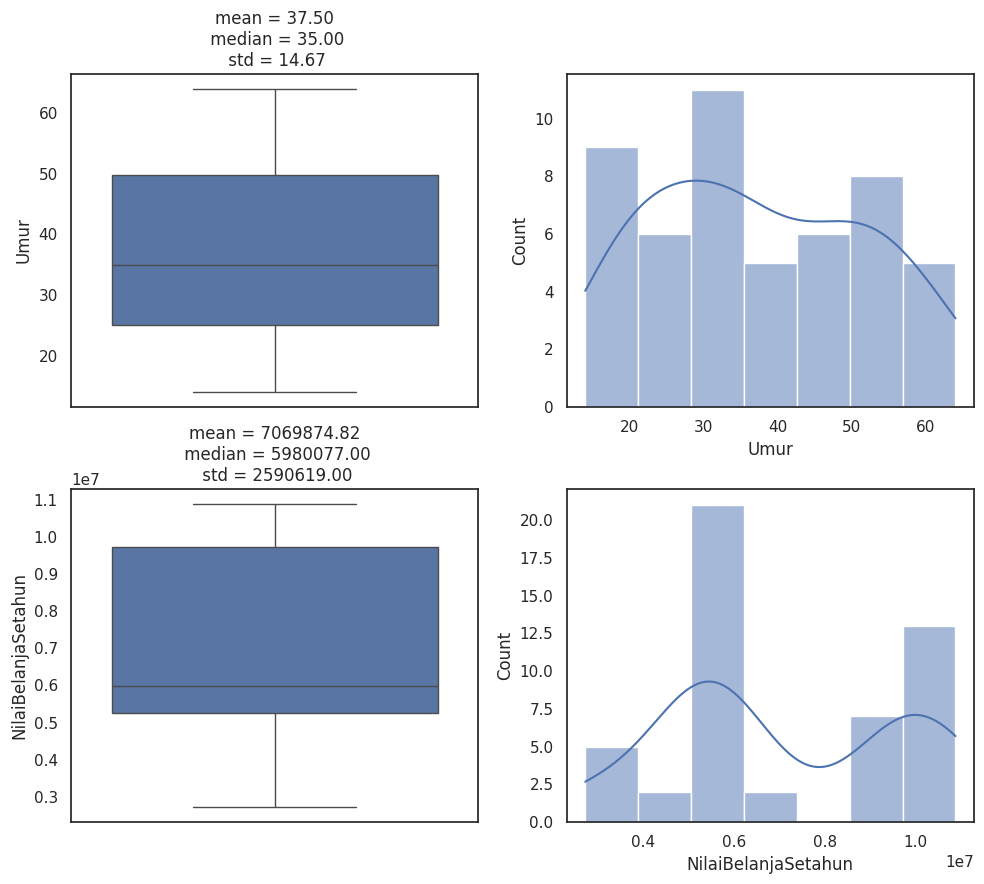

In [107]:
sns.set(style='white')
plt.clf()

# Fungsi untuk membuat plot
def observasi_num(features):
    fig, axs = plt.subplots(2, 2, figsize=(10, 9))
    for i, kol in enumerate(features):
        sns.boxplot(df[kol], ax=axs[i][0])
        sns.histplot(df[kol], ax=axs[i][1], kde=True)
        axs[i][0].set_title(
            'mean = %.2f\n median = %.2f\n std = %.2f' % (
                df[kol].mean(),
                df[kol].median(),
                df[kol].std()))
    plt.tight_layout()
    plt.show()
    plt.close('all')

# Memanggil fungsi untuk membuat Plot untuk data numerik
kolom_numerik = ['Umur', 'NilaiBelanjaSetahun']
observasi_num(kolom_numerik)

# **Eksplorasi Data Kategorikal**

Dalam analisis data kategorikal, distribusi pelanggan berdasarkan jenis kelamin menunjukkan bahwa mayoritas pelanggan adalah wanita, dengan jumlah mencapai 41 orang atau sekitar 82% dari total sampel. Sedangkan pelanggan pria berjumlah 9 orang, yang mewakili sekitar 18%. Dominasi ini mengindikasikan bahwa segmen pelanggan wanita merupakan kelompok utama dalam dataset ini.

Selanjutnya, pada variabel profesi, kelompok wiraswasta mendominasi dengan proporsi sebesar 40% dari keseluruhan pelanggan, diikuti oleh profesional yang mencakup sekitar 36%. Sisanya, sebanyak 24%, tersebar di kategori lain seperti pelajar, ibu rumah tangga, dan mahasiswa. Komposisi ini memberikan gambaran bahwa pelanggan dengan latar belakang wiraswasta dan profesional merupakan segmen yang signifikan dalam populasi pelanggan.

Untuk tipe residen, mayoritas pelanggan tinggal di area cluster, yaitu sebanyak 64% dari total pelanggan, sedangkan sisanya, sebesar 36%, tinggal di sector. Distribusi ini menunjukkan kecenderungan lokasi tempat tinggal pelanggan yang dapat menjadi faktor penting dalam segmentasi pasar.



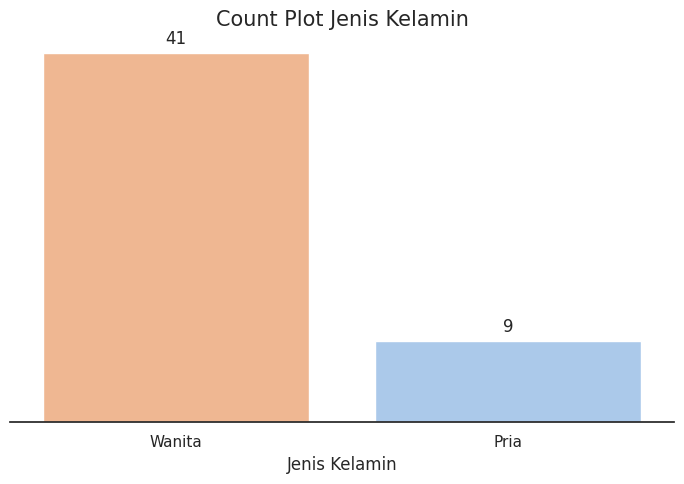

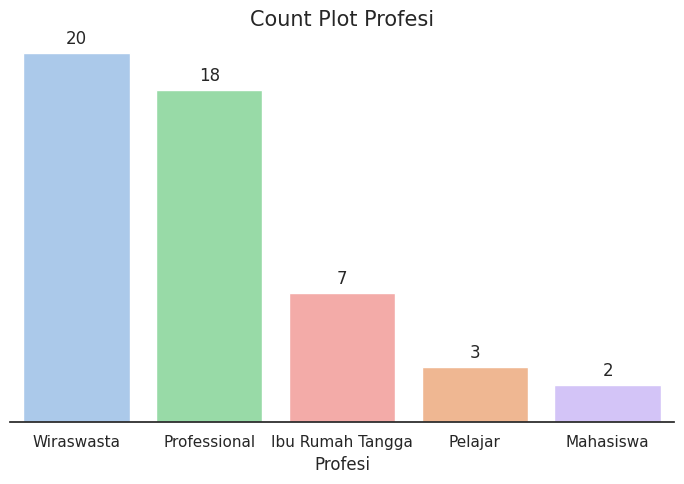

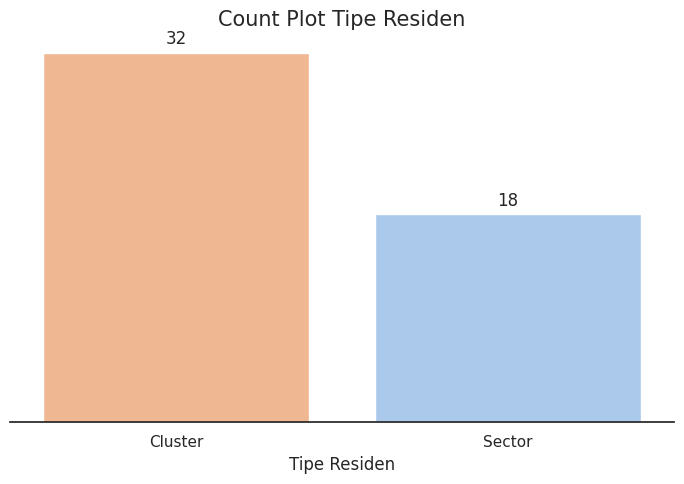

In [122]:
sns.set(style='white')

# Kolom kategorikal
kolom_kategorikal = ['Jenis Kelamin', 'Profesi', 'Tipe Residen']

# Membuat plot untuk setiap kolom kategorikal
for kol in kolom_kategorikal:
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.countplot(data=df, x=kol, hue=kol, order=df[kol].value_counts().index, ax=ax, palette='pastel', legend=False)
    ax.set_title(f'Count Plot {kol}', fontsize=15)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

    sns.despine(right=True, top=True, left=True)
    ax.axes.yaxis.set_visible(False)
    plt.tight_layout()
    plt.savefig(f'countplot_{kol}.png')

plt.show()

# **Standarisasi Kolom Numerik**

Karena variabel numerik memiliki skala yang berbeda, dilakukan standarisasi agar setiap variabel memiliki rata-rata nol dan standar deviasi satu. Proses ini penting untuk memastikan bahwa variabel numerik tidak mendominasi dalam analisis clustering yang melibatkan data campuran. Setelah standarisasi, distribusi data menjadi lebih seimbang dan siap digabungkan dengan data kategorikal yang sudah diubah menjadi bentuk numerik.

In [109]:
kolom_numerik = ['Umur','NilaiBelanjaSetahun']

# Statistik sebelum Standardisasi
print('Statistik Sebelum Standardisasi\n')
display(df[kolom_numerik].describe().round(1))

# Standardisasi
df_std = StandardScaler().fit_transform(df[kolom_numerik])

# Membuat DataFrame
df_std = pd.DataFrame(data=df_std, index=df.index, columns=df[kolom_numerik].columns)

# Menampilkan contoh isi data dan summary statistic
print('Contoh hasil standardisasi\n')
display(df_std.head())

print('Statistik hasil standardisasi\n')
display(df_std.describe().round(0))

Statistik Sebelum Standardisasi



,Umur,NilaiBelanjaSetahun
count,50.0,50.0
mean,37.5,7069874.8
std,14.7,2590619.0
min,14.0,2722700.0
25%,25.0,5257529.8
50%,35.0,5980077.0
75%,49.8,9739615.0
max,64.0,10884508.0


Contoh hasil standardisasi



,Umur,NilaiBelanjaSetahun
0,1.411245,0.946763
1,-1.617768,-1.695081
2,0.722833,-0.695414
3,1.067039,-0.727361
4,0.240944,1.382421


Statistik hasil standardisasi



,Umur,NilaiBelanjaSetahun
count,50.0,50.0
mean,-0.0,-0.0
std,1.0,1.0
min,-2.0,-2.0
25%,-1.0,-1.0
50%,-0.0,-0.0
75%,1.0,1.0
max,2.0,1.0


# **Konversi Kategorikal Data dengan Label Encoder**

Data kategorikal diubah menjadi format numerik menggunakan Label Encoder agar dapat diproses oleh algoritma clustering. Setiap kategori unik pada kolom seperti jenis kelamin, profesi, dan tipe residen diberi kode angka yang berbeda secara konsisten. Transformasi ini memungkinkan algoritma untuk mengenali dan mengelompokkan data berdasarkan kategori tersebut tanpa kehilangan informasi penting.

In [110]:
# Inisiasi nama kolom kategorikal
kolom_kategorikal = ['Jenis Kelamin','Profesi','Tipe Residen']

# Membuat salinan data frame
df_encode = df[kolom_kategorikal].copy()

# Melakukan labelEncoder untuk semua kolom kategorikal
for col in kolom_kategorikal:
    df_encode[col] = LabelEncoder().fit_transform(df_encode[col])

# Menampilkan data
df_encode.head()

,Jenis Kelamin,Profesi,Tipe Residen
0,0,4,1
1,1,2,0
2,0,3,0
3,0,3,0
4,1,4,0


# **Menggabungkan Data untuk Permodelan**

Setelah data numerik distandarisasi dan data kategorikal di-encode, kedua jenis data ini digabungkan menjadi satu dataframe yang siap digunakan untuk pemodelan clustering. Penggabungan ini mempertahankan konsistensi data berdasarkan indeks yang sama, sehingga setiap baris data merepresentasikan satu pelanggan dengan seluruh atribut yang telah diproses. Data yang sudah siap ini menjadi dasar untuk langkah berikutnya yaitu penerapan algoritma clustering guna mengelompokkan pelanggan berdasarkan karakteristik mereka.

In [111]:
# Menggabungkan data frame
df_model= df_encode.merge(df_std, left_index = True, right_index=True, how= 'left')
df_model.head()

,Jenis Kelamin,Profesi,Tipe Residen,Umur,NilaiBelanjaSetahun
0,0,4,1,1.411245,0.946763
1,1,2,0,-1.617768,-1.695081
2,0,3,0,0.722833,-0.695414
3,0,3,0,1.067039,-0.727361
4,1,4,0,0.240944,1.382421
